In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
import neurolab
import scipy
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
%matplotlib inline

In [231]:
bienici = pd.read_csv("scraping_bienici.csv")

In [232]:
print(bienici.head())
print(bienici.columns)

                                                 url     scraping_date  \
0  https://www.bienici.com/annonce/location//appa...  2016-10-09@00:30   
1  https://www.bienici.com/annonce/location//appa...  2016-10-09@00:30   
2  https://www.bienici.com/annonce/location//appa...  2016-10-09@00:30   
3  https://www.bienici.com/annonce/location/paris...  2016-10-09@00:30   
4  https://www.bienici.com/annonce/location/paris...  2016-10-09@00:30   

                        title   price  charges  \
0  Appartement 2 pièces 36 m²  1150.0     70.0   
1  Appartement 2 pièces 36 m²  1150.0     70.0   
2  Appartement 3 pièces 85 m²  2165.0    165.0   
3                Studio 31 m²   930.0    105.0   
4                Studio 35 m²  1200.0      NaN   

                                           place  surface  construction_year  \
0                   - Grandes Carrières - Clichy     36.0                NaN   
1                   - Grandes Carrières - Clichy     36.0                NaN   
2             

#### The ratio charges/prices seems pretty constant. We can get a estimate of the charges using this fact;

/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


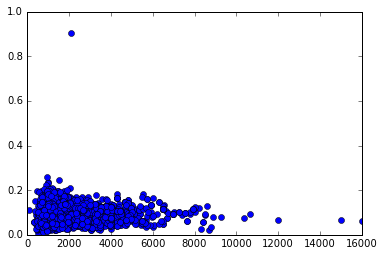

In [233]:
def get_weird(x):
    return re.compile("[0-9]+\sà").match(x) is None

cleaned_price = bienici.ix[bienici["price"].apply(get_weird, 0),:]
cleaned_price["price"] = cleaned_price["price"].apply(float)
cleaned_price["ratio"] = cleaned_price.charges/cleaned_price.price
plt.plot(cleaned_price["price"],cleaned_price["ratio"], "o")
plt.show()

In [234]:
cleaned_price["surface_by_room"] = cleaned_price["surface"]/cleaned_price["number_rooms"]
cleaned_price[["price", "charges","surface", "number_rooms", "number_bedrooms", "surface_by_room"]].corr()

/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,price,charges,surface,number_rooms,number_bedrooms,surface_by_room
price,1.000000,0.821315,0.869920,0.429128,0.659591,0.468246
charges,0.821315,1.000000,0.820388,0.729083,0.667019,0.394402
surface,0.869920,0.820388,1.000000,0.525953,0.840922,0.512903
number_rooms,0.429128,0.729083,0.525953,1.000000,0.921765,0.060566
number_bedrooms,0.659591,0.667019,0.840922,0.921765,1.000000,0.372341
surface_by_room,0.468246,0.394402,0.512903,0.060566,0.372341,1.000000


#### As expected, all these features are pretty highly correlated - surface by room is the only exception . The features which makes the most sense is the surface. We can get rid of the others.

In [235]:
bienici = bienici.ix[bienici["price"].apply(get_weird, 0),:]
bienici["price"] = bienici["price"].apply(float)
bienici["estimated_charges"] = bienici.price*0.09
dataset = bienici.drop(["price", "number_rooms", "number_bedrooms"], 1)
dataset.head()

,url,scraping_date,title,charges,place,surface,construction_year,description,number_pictures,furnished,...,contact,contact_address,contact_rcs,contact_type,ref_annonce,publication_date,modification_date,infos_quartier,other_info,estimated_charges
0,https://www.bienici.com/annonce/location//appa...,2016-10-09@00:30,Appartement 2 pièces 36 m²,70.0,- Grandes Carrières - Clichy,36.0,NaN,Description HTML_format -- Haut Rue Damr&eacut...,6,Yes,...,Acopa Damrémont,19 Rue Damrémont - 75018 Paris,RCS : 512097031,Agence,3987,5 oct. 2016,NaN,"<span><a href=""/decouvrez/paris/paris-18e/gran...",Exposé Est \n\&\\n1 WC\n\&\\n,103.50
1,https://www.bienici.com/annonce/location//appa...,2016-10-09@00:30,Appartement 2 pièces 36 m²,70.0,- Grandes Carrières - Clichy,36.0,NaN,Description HTML_format -- Haut Rue Damr&eacut...,6,Yes,...,Acopa Damrémont,19 Rue Damrémont - 75018 Paris,RCS : 512097031,Agence,3989,6 oct. 2016,NaN,"<span><a href=""/decouvrez/paris/paris-18e/gran...",Exposé Est \n\&\\n1 WC\n\&\\n,103.50
2,https://www.bienici.com/annonce/location//appa...,2016-10-09@00:30,Appartement 3 pièces 85 m²,165.0,- Jules Joffrin,85.0,NaN,Description HTML_format -- Appartement 3/4 pi&...,11,No,...,Acopa Immobilière Marcadet,77 Bd Barbes - 75018 Paris,RCS : 70305443384,Agence,3956,16 sept. 2016,NaN,"<span><a href=""/decouvrez/paris/paris-18e/jule...",NaN,194.85
3,https://www.bienici.com/annonce/location/paris...,2016-10-09@00:30,Studio 31 m²,105.0,Paris 10e 75010 - Grange aux Belles - Terrage,31.0,NaN,"République - Studio de 31 m². M° République, à...",5,No,...,CONSULT IM - CONSULT'IM,"17, Rue De Chateaudun - 75009 Paris",RCS : 511411324,Agence,10185379,7 oct. 2016,NaN,"<span><a href=""/decouvrez/paris/paris-10e/gran...",NaN,83.70
4,https://www.bienici.com/annonce/location/paris...,2016-10-09@00:30,Studio 35 m²,NaN,Paris 10e 75010 - Porte Saint-Denis - Paradis,35.0,1700.0,"REF. 5069 - Studio meublé d'environ 35 m², sit...",12,Yes,...,BOOK A FLAT,18 Rue Volney - 75002 Paris,RCS : 478 941 990,Agence,5069,22 sept. 2016,NaN,"<span><a href=""/decouvrez/paris/paris-10e/port...",1 200 €\n\&\\n1 WC\n\&\\nDisponible le 1 décem...,108.00


#### Do furnitures increase the charges ? It's not obvious at first glance. We put it aside for the moment. On the contrary, the presence of a lift increases the charges.

In [236]:
def furnished_sure(x):
    ret = False
    if x == 'Yes':
        ret = True
    return ret
# vec_furnished gives the position of ads where it is sure that furnished is true
vec_furnished_sure = np.asarray(bienici["furnished"].apply(furnished_sure, 1)).astype(int)

def furnished_from_mining(x):
    ret = False
    if 'meublé' in x and 'non meublé' not in x and 'non-meublé' not in x and 'non meuble' not in x\
    and 'non-meuble' not in x:
        ret = True
    return ret
# vec_furnished_minig gives the position of ads where we found that the flat is furnished, thanks to the description
vec_furnished_mining = np.asarray(bienici["description"].apply(furnished_from_mining, 1)).astype(int)
vec_furnished = vec_furnished_sure + vec_furnished_mining
vec_furnished = (vec_furnished >= 1).astype(int) # 0/1 format

bienici["furnished"] = vec_furnished

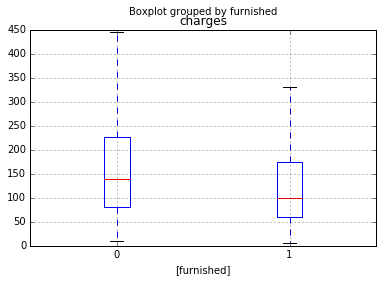

In [237]:
bienici[["charges", "furnished"]].boxplot(by = "furnished", showfliers = False)
plt.show()

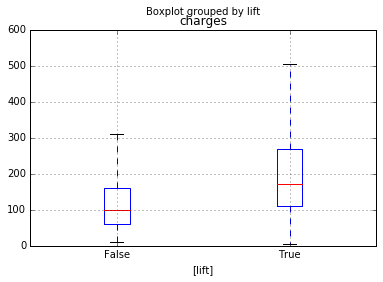

In [238]:
bienici["lift"] = bienici["lift"].fillna(False)
bienici[["charges", "lift"]].boxplot(by = "lift", showfliers = False)
plt.show()

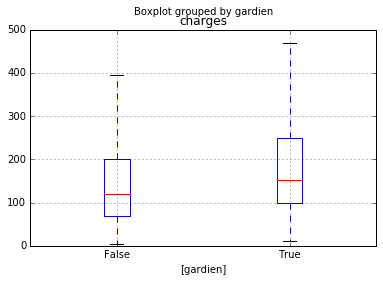

In [239]:
def find_gardien(x):
    if 'gardien' in x:
        return True
    else:
        return False

bienici["gardien"] = bienici["description"].apply(find_gardien, 0)
dataset["gardien"] = bienici["gardien"]
bienici[["charges", "gardien"]].boxplot(by = "gardien", showfliers = False)
plt.show()

### We now anlyse the impact of the heating system on the charges. We expect this feature will have a real effect.

In [240]:
bienici["heating"] = bienici["heating"].str.lower()
bienici["heating"] = bienici["heating"].fillna("")
bienici["heating"] = bienici["heating"].str.replace("é", "e")
print(bienici.heating.unique())

['gaz individuel ' '' 'collectif' 'individuel' 'electricite ' 'convecteur '
 'electricite' 'radiateur electricite ' 'collectif ' 'gaz '
 'radiateur gaz individuel ' 'radiateur gaz collectif'
 'individuel electrique electricite' 'collectif radiateurs'
 'individuel electricite' 'radiateur gaz ' 'radiateur fioul '
 'convecteur electricite ' 'convecteurs electricite individuel '
 'radiateurs gaz collectif ' 'individuel gaz gaz' 'radiateur '
 'radiateur collectif ' 'radiateur gaz collectif ' 'electricite individuel'
 'radiateur individuel' 'gaz individuel' 'electrique individuel '
 'radiateur collectif' 'radiateur fuel collectif '
 'convecteur electricite individuel' 'individuel au gaz' 'electrique '
 'individuel electrique' 'individuel ' 'radiateur gaz individuel'
 'gaz collectif' 'radiateur electricite individuel'
 'radiateurs cpcu collectif ' 'sol collectif ' 'fioul '
 'radiateurs gaz individuel ' 'radiateur individuel ' 'urbain collectif '
 'radiateur gaz' 'radiateur cpcu collectif ' 'f

In [241]:
def get_coll(system):
    if re.compile("collectif").match(system):
        return "collectif"
    elif re.compile("individuel").match(system):
        return "individuel"
    else:
        return "unknown"
    
bienici["heating_sys"] = bienici["heating"].apply(get_coll, 0)
bienici["heating_sys"].value_counts()

unknown       3350
collectif      552
individuel     427
Name: heating_sys, dtype: int64

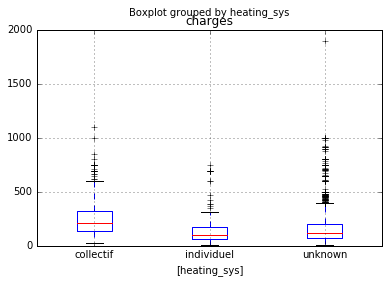

In [242]:
bienici[["heating_sys", "charges"]].boxplot(by = "heating_sys")
plt.show()

#### Collective heating system increases the charges. We now dive into the effect of the energy source:

In [243]:
def get_source(system):
    if re.compile("electricite").match(system) or re.compile("electrique").match(system):
        return "electricite"
    elif re.compile("gaz").match(system):
        return "gaz"
    elif re.compile("fuel").match(system) or re.compile("fioul").match(system):
        return "fuel"
    else:
        return "unknown"
    
bienici["heating_source"] = bienici["heating"].apply(get_source, 0)
bienici["heating_source"].value_counts()

unknown        3603
electricite     378
gaz             321
fuel             27
Name: heating_source, dtype: int64

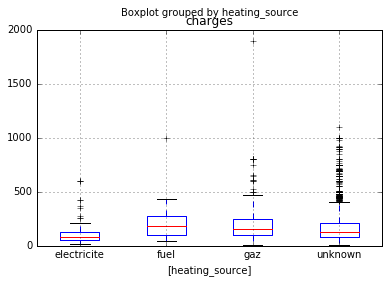

In [244]:
bienici[["heating_source", "charges"]].boxplot(by = "heating_source")
plt.show()

#### Electricity based heating systems are way cheaper than the others. The fuel based ones tend to be more expensive.

In [245]:
dataset = dataset.drop(["heating"], 1)
dataset["heating_source"] = bienici["heating_source"] 
dataset["heating_sys"] = bienici["heating_sys"] 

### Checking the influence of the floor's number on the charges: 

In [246]:
print(bienici.floor.unique())
bienici["floor"] = bienici["floor"].fillna("")
bienici["floor"] = bienici["floor"].str.lower()

['5e étage (sur 6)' '4e étage (sur 6)' nan '1er étage' 'Rez-de-chaussée'
 '4e étage' '5e étage' '2e étage' '2e étage (sur 6)' '3e étage (sur 5)'
 '6e étage' '3e étage' '3e étage (sur 4)' '1er étage (sur 6)'
 'Dernier étage (sur 4)' '3e étage (sur 8)' '6 étages' '6e étage (sur 7)'
 'Dernier étage (sur 3)' 'Dernier étage (sur 6)' '3e étage (sur 6)'
 '3e étage (sur 10)' '8e étage' '1er étage (sur 4)' '4e étage (sur 5)'
 'Dernier étage (sur 1)' '4e étage (sur 7)' '1er étage (sur 2)' '40e étage'
 '2e étage (sur 7)' '5e étage (sur 10)' '4e étage (sur 10)' '7e étage'
 '4e étage (sur 8)' '4 étages' '10e étage' '1er étage (sur 10)' '5 étages'
 'Dernier étage (sur 5)' '2e étage (sur 8)' '1er étage (sur 7)'
 'Dernier étage (sur 11)' '1er étage (sur 13)' '6e étage (sur 9)'
 '11e étage' 'Dernier étage (sur 7)' '1er étage (sur 3)'
 '16e étage (sur 28)' '26e étage (sur 31)' '2e étage (sur 5)' '24e étage'
 '4e étage (sur 9)' '11e étage (sur 30)' '24e étage (sur 30)'
 '7e étage (sur 9)' '10e étage (sur

In [247]:
def get_floor(floor):
    if re.compile("^[0-9]+").match(floor):
        return min(9,int(re.search(r"^[0-9]+", floor).group(0)))
    elif re.compile("^dernier").match(floor):
        return min(9, int(re.search(r"[0-9]+", floor).group(0)))

    return "unknown"
    
bienici["floor"] = bienici["floor"].apply(get_floor, 0)
print(bienici["floor"].value_counts())

unknown    1083
1           580
2           533
3           525
4           512
5           425
6           408
7           130
9            81
8            52
Name: floor, dtype: int64


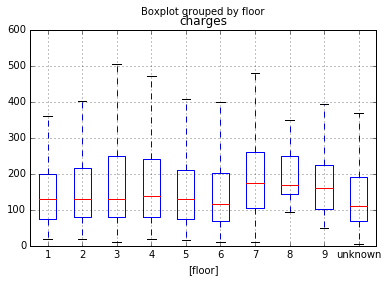

In [248]:
bienici[["floor", "charges"]].boxplot(by = "floor", showfliers = False)
plt.show()

#### The differences in charges are not that obvious. We drop this feature.

In [249]:
dataset = dataset.drop(["floor"], 1)

### Now, we look at the time the building was built. The two variables are not correlated.

In [250]:
print(bienici[["charges", "construction_year"]].corr())
dataset = dataset.drop(["construction_year"], 1)

                    charges  construction_year
charges            1.000000          -0.023922
construction_year -0.023922           1.000000


### Check expo

In [251]:
bienici.other_info

0                           Exposé Est \n\&\\n1 WC\n\&\\n
1                           Exposé Est \n\&\\n1 WC\n\&\\n
2                                                     NaN
3                                                     NaN
4       1 200 €\n\&\\n1 WC\n\&\\nDisponible le 1 décem...
5       1 350 €\n\&\\nTerrasse\n\&\\n1 WC\n\&\\nDispon...
6          1 195 €\n\&\\n1 terrasse\n\&\\n1 balcon\n\&\\n
7                                                     NaN
8       1 balcon\n\&\\nExposé Sud-Est\n\&\\n1 cave\n\&\\n
9       910 €\n\&\\n1 balcon\n\&\\n1 WC\n\&\\nDigicode...
10               1 060 €\n\&\\n1 WC\n\&\\nDigicode\n\&\\n
11                                           720 €\n\&\\n
12                                                    NaN
13                                                    NaN
14      1 cave\n\&\\nWC séparés\n\&\\nDigicode\n\&\\nI...
15            1 WC\n\&\\nDigicode\n\&\\nInterphone\n\&\\n
16                                            1 WC\n\&\\n
17            

In [252]:
bienici["other_info"] = bienici["other_info"].fillna("")
bienici["other_info"] = bienici["other_info"].str.lower()

In [253]:
def get_expo(info):
    regex = re.compile("exposé\s[a-z]+-?[a-z]*").match(info)
    if regex:
        return regex.group(0).replace("exposé ", "") 
    else:
        return "unknown"

In [254]:
bienici["expo"] = bienici["other_info"].apply(get_expo, 0)

In [255]:
bienici["expo"].unique()

array(['est', 'unknown', 'sud', 'sud-est', 'ouest', 'nord', 'nord-ouest',
       'traversant', 'sud-ouest', 'est-ouest', 'nord-est'], dtype=object)

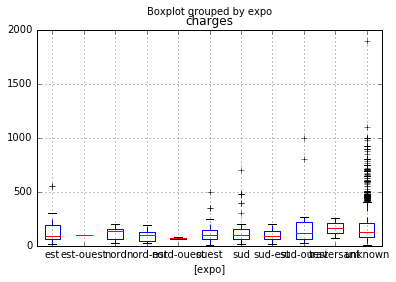

In [256]:
bienici[["charges", "expo"]].boxplot(by = "expo")
plt.show()

In [257]:
bienici["expo"].value_counts()

unknown       4164
sud             64
ouest           31
est             25
nord            13
sud-est         11
sud-ouest       11
nord-est         5
nord-ouest       2
traversant       2
est-ouest        1
Name: expo, dtype: int64

#### Not enough informations about flat orientation. It's not interesting to take it into account.

In [258]:
dataset = dataset.drop(["other_info"], 1)

In [259]:
bienici.place.unique()

array([' - Grandes Carrières - Clichy', ' - Jules Joffrin',
       'Paris 10e\xa075010 - Grange aux Belles - Terrage',
       'Paris 10e\xa075010 - Porte Saint-Denis - Paradis',
       "Paris 10e\xa075010 - Château d'Eau - Lancry",
       'Paris 10e\xa075010 - Louis Blanc - Aqueduc', 'Paris 10e\xa075010',
       'Paris 10e\xa075010 - Faubourg du Temple - Hôpital Saint-Louis',
       'Paris 10e\xa075010 - Saint-Vincent de Paul - Lariboisière',
       'Paris 11e\xa075011', 'Paris 11e\xa075011 - Bastille - Popincourt',
       'Paris 11e\xa075011 - Belleville - Saint-Maur',
       'Paris 11e\xa075011 - Nation - Alexandre Dumas',
       'Paris 11e\xa075011 - Léon-Blum - Folie-Regnault',
       'Paris 11e\xa075011 - République - Saint-Ambroise',
       'Paris 11e\xa075011 - Les Halles',
       'Paris 12e\xa075012 - Bel-Air - Sud',
       'Paris 12e\xa075012 - Aligre - Gare de Lyon', 'Paris 12e\xa075012',
       'Paris 12e\xa075012 - Vallée de Fecamp',
       'Paris 12e\xa075012 - Jardin de R

In [260]:
def get_district(place):
    regex = re.compile("Paris\s[0-9]+").match(place)
    if regex:
        return regex.group(0)
    else:
        return "unknown"
    
    
### Fonction pas à jour !!
def get_quarter(place):
    quarter = place.split("-", 1)
    if len(quarter) > 0:
        return quarter[1]
    else:
        return "unknown"   

In [261]:
bienici["district"] = bienici["place"].apply(get_district, 0)


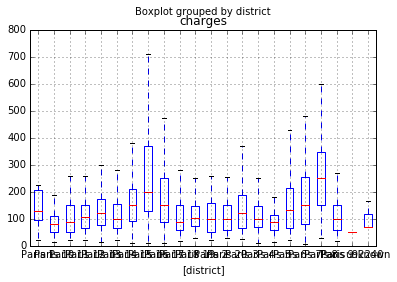

In [262]:
bienici[["district", "charges"]].boxplot(by = "district", showfliers = False)
plt.show()

#### Not enough observations by quarter. We drop it.

In [263]:
dataset["district"] = bienici["district"]
dataset = dataset.drop(["url", "scraping_date", "title", "description", "number_pictures", "number_bathromms", "contact",
                       "contact_address", "contact_rcs", "contact_type", "ref_annonce", "publication_date", "modification_date",
                        "infos_quartier", "place"], 1)

In [264]:
dataset.head()

,charges,surface,furnished,lift,estimated_charges,gardien,heating_source,heating_sys,district
0,70.0,36.0,Yes,NaN,103.50,False,gaz,unknown,unknown
1,70.0,36.0,Yes,NaN,103.50,False,gaz,unknown,unknown
2,165.0,85.0,No,NaN,194.85,False,unknown,unknown,unknown
3,105.0,31.0,No,NaN,83.70,False,unknown,collectif,Paris 10
4,NaN,35.0,Yes,NaN,108.00,False,unknown,individuel,Paris 10


In [265]:
dataset = dataset.ix[np.abs(dataset.charges - dataset.charges.mean()) < 2.5*dataset.charges.std(), :]
dataset["charges_log"] = dataset["charges"].apply(np.log, 0)
dataset["estimate_log"] = dataset["estimated_charges"].apply(np.log, 0)
dataset = dataset.drop(["charges", "estimated_charges"], 1)

In [266]:
dataset.head()

,surface,furnished,lift,gardien,heating_source,heating_sys,district,charges_log,estimate_log
0,36.0,Yes,NaN,False,gaz,unknown,unknown,4.248495,4.639572
1,36.0,Yes,NaN,False,gaz,unknown,unknown,4.248495,4.639572
2,85.0,No,NaN,False,unknown,unknown,unknown,5.105945,5.272230
3,31.0,No,NaN,False,unknown,collectif,Paris 10,4.653960,4.427239
7,28.0,No,NaN,False,unknown,unknown,Paris 10,4.744932,4.394449


In [267]:
dataset = dataset.ix[dataset["charges_log"].notnull(), :]
dataset["lift"] = dataset["lift"].fillna(False)

In [268]:
dataset = dataset.dropna()
dataset[["collectif", "individuel"]] = pd.get_dummies(dataset["heating_sys"]).drop(["unknown"], 1)
dataset = dataset.drop(["heating_sys"], 1)

In [269]:
dataset = pd.concat([dataset, pd.get_dummies(dataset["district"]).drop(["unknown"], 1)], 1)
dataset = dataset.drop(["district"], 1)
dataset = pd.concat([dataset, pd.get_dummies(dataset["heating_source"]).drop(["unknown"],1)], 1).drop(["heating_source"], 1)

In [270]:
dataset["furnished"][dataset["furnished"] == "Yes"] = 1
dataset["furnished"][dataset["furnished"] == "No"] = 0

/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [271]:
split = np.random.randint(1, 4, dataset.shape[0])
Train = dataset.ix[split != 3, :]
Test = dataset.ix[split == 3, :]

In [272]:
X_train = Train[[col for col in dataset.columns if col != "charges_log"]]
Y_train = Train[["charges_log"]]
X_test = Test[[col for col in dataset.columns if col != "charges_log"]]
Y_test = Test[["charges_log"]]

In [273]:
forest = RandomForestRegressor(n_estimators = 1000)
forest.fit(X_train, Y_train)
y_hat = forest.predict(X_test)

/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [274]:
errors = np.exp(Y_test.charges_log) - np.exp(y_hat)
error_abs = np.abs(errors)
print(np.mean(np.abs(np.exp(Y_test.charges_log) - np.exp(y_hat))))
print(np.percentile((np.abs(np.exp(Y_test.charges_log) - np.exp(y_hat))), [25, 50, 75, 90]))

34.26122057511717
[  9.00394763  23.69696599  47.97251642  79.75295394]


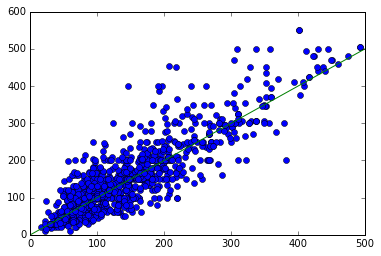

In [275]:
plt.plot(np.exp(y_hat), np.exp(Y_test.charges_log), "o")
x = np.linspace(0, 500, 2)
plt.plot(x, x)
plt.show()

In [226]:
error_abs_u200 = error_abs[np.exp(Y_test.charges_log) < 200]

In [227]:
print(np.mean(np.abs(error_abs_u200)))
print(np.percentile(error_abs_u200, [25, 50, 75, 90]))

28.96581562306324
[  9.17672102  21.93779057  41.30410521  64.41889067]


In [228]:
error_abs_a200 = error_abs[np.exp(Y_test.charges_log) > 200]
print(np.mean(np.abs(error_abs_a200)))
print(np.percentile(error_abs_a200, [25, 50, 75, 90]))

61.909533687328064
[  10.16472237   47.05459535   98.84492712  141.09838643]


In [229]:
u200 = dataset.ix[np.exp(dataset.charges_log) < 200, :]
split = np.random.randint(1, 4, u200.shape[0])
Train_u200 = u200.ix[split != 3, :]
Test_u200 = u200.ix[split == 3, :]
X_train = Train_u200[[col for col in u200.columns if col != "charges_log"]]
Y_train = Train_u200[["charges_log"]]
X_test = Test_u200[[col for col in u200.columns if col != "charges_log"]]
Y_test = Test_u200[["charges_log"]]
forest = RandomForestRegressor()
forest.fit(X_train, Y_train)
y_hat = forest.predict(X_test)

/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [178]:
errors = np.exp(Y_test.charges_log) - np.exp(y_hat)
error_abs = np.abs(errors)
print(np.mean(np.abs(np.exp(Y_test.charges_log) - np.exp(y_hat))))
print(np.percentile((np.abs(np.exp(Y_test.charges_log) - np.exp(y_hat))), [25, 50, 75, 90]))

25.309840067482508
[  7.17135918  18.57656669  37.43708963  59.00294476]


### Error of the global model in percentage:

In [276]:
percent = error_abs/Y_test.charges_log
print(np.mean(percent))
print(np.percentile(percent, [25, 50, 75, 90]))

6.924386838408603
[  1.94345917   5.18608204  10.07614348  15.67402487]


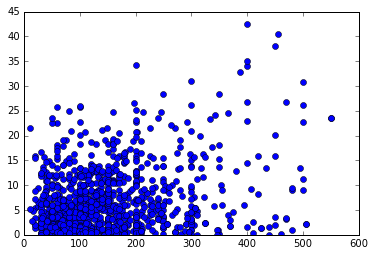

In [277]:
plt.plot(np.exp(Y_test.charges_log), percent, "o")
plt.show()